<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. BERT Pre-trained Model 및 환경셋팅
1) 아래의 BERT사이트에 접속하여 BERT-BASE 모델 다운로드
* https://github.com/google-research/bert  
* BERT-Base, Multilingual Cased: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters

2) 다운로드된 파일을 구글 드라이브에 업로드

  * 압축 풀기 후 폴더 업로드: multi_cased_L-12_H-768_A-12
*   제공된 소스파일과 데이터 업로드: 13.BERT Classification.ipynb, spam_text.csv, spam_train.csv



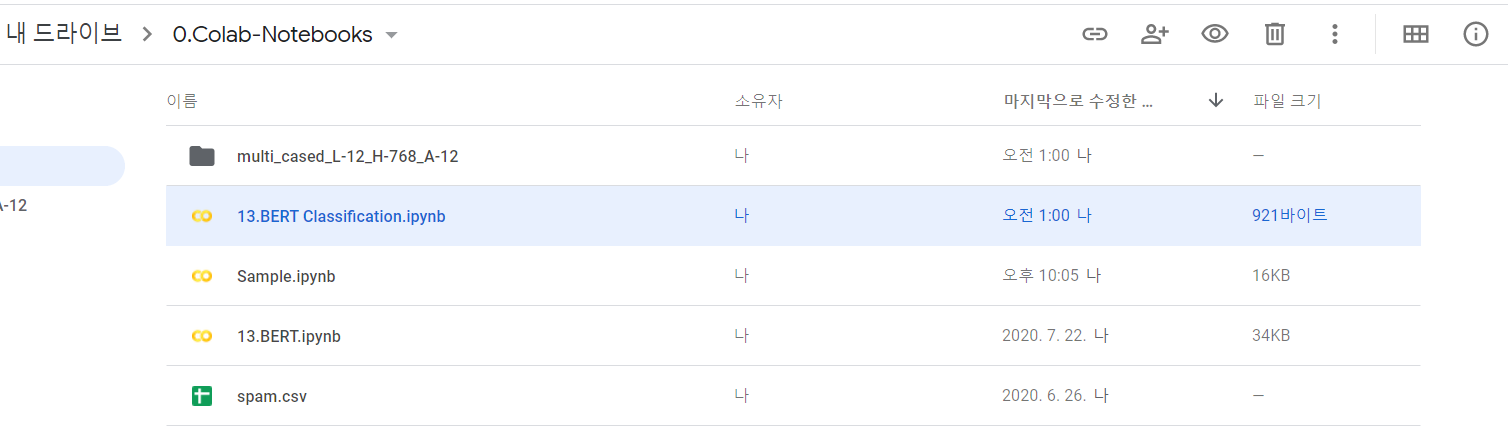

3) 구글드라이브와 Colab 연동

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# 마운트된 내 드라이브와 파일 확인
!ls

'13.BERT Classification.ipynb'	 nsmc		 spam_train.csv
 multi_cased_L-12_H-768_A-12	 spam_test.csv


In [ ]:
cd /content/drive/My\ Drive/0.Colab/BERT

/content/drive/My Drive/0.Colab/BERT


In [ ]:
print(os.getcwd())
!ls

/content/drive/My Drive/0.Colab/BERT
'13.BERT Classification.ipynb'	 nsmc		 spam_train.csv
 multi_cased_L-12_H-768_A-12	 spam_test.csv


In [ ]:
# 현재 작업폴더를 변수처리
workPath = '/content/drive/My Drive/0.Colab/BERT'
os.listdir(workPath)

['13.BERT Classification.ipynb',
 'multi_cased_L-12_H-768_A-12',
 'nsmc',
 'spam_train.csv',
 'spam_test.csv']

## 2. 관련 패키지 설치

In [ ]:
#pip install tensorflow==1.5

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
# Adam optimizer의 수정판인 keras-radam 설치
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34143 sha256=1823da4f183bc803a38f74611f93a16c456ebfa3cbe4a6291ad0ae1e68848836
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12942 sha256=331490f1b6545bb6d930c3e19994509c4f3ac6c4458f4abdad89c9c344cf3b69
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=62fbed1b6f7fa17363755bb193c93f3deb0f9a6963b3b4e11db71b2624293d65
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15611 sha256=5cd3e7e0798824946c60243cb4fd41d3c31c829ac3fb34f5f3f46dd25348236d
  Stor

  Created wheel for keras-radam: filename=keras_radam-0.15.0-cp36-none-any.whl size=14685 sha256=3d2dfa1d249f212610222d135bdd989cf53b5229e97090a79fc077526fc90900
  Stored in directory: /root/.cache/pip/wheels/79/a0/c0/670b0a118e8f078539fafec7bd02eba0af921f745660c7f83f
Successfully built keras-radam


In [ ]:
# keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈 Import
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps
from keras_radam import RAdam

In [ ]:
os.listdir(workPath)

['13.BERT Classification.ipynb',
 'multi_cased_L-12_H-768_A-12',
 'nsmc',
 'spam_train.csv',
 'spam_test.csv']

## 3. 스팸데이터셋 준비

In [ ]:
# 제공된 Spam data 읽기
train = pd.read_csv("spam_train.csv")
test = pd.read_csv("spam_test.csv")

In [ ]:
# Label의 1은 spam document에 해당함, 0은 정상 
train[50:70]

,label,document,Unnamed: 2,Unnamed: 3,Unnamed: 4
50,0,Rofl betta invest in some anti aging products,NaN,NaN,NaN
51,1,You are a winner U have been specially selecte...,NaN,NaN,NaN
52,0,"sir, you will receive the account no another 1...",NaN,NaN,NaN
53,1,Reply with your name and address and YOU WILL ...,NaN,NaN,NaN
54,0,So �_'ll be submitting da project tmr rite?,NaN,NaN,NaN
55,1,FREE entry into our �250 weekly comp just send...,NaN,NaN,NaN
56,0,Jus ans me lar. U'll noe later.,NaN,NaN,NaN
57,0,I want to send something that can sell fast. ...,NaN,NaN,NaN
58,0,have got * few things to do. may be in * pub l...,NaN,NaN,NaN
59,0,1's finish meeting call me.,NaN,NaN,NaN


In [ ]:
# 불필요한 컬럼 삭제
del train['Unnamed: 2']
del train['Unnamed: 3']
del train['Unnamed: 4']

del test['Unnamed: 2']
del test['Unnamed: 3']
del test['Unnamed: 4']

## 4. BERT 훈련 모델 설정

bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.
BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 16으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 1e-5로 작게 정했습니다.
pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 스팸인지 정상인지 알려주는 칼럼을 label로 정해줍니다

In [ ]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="multi_cased_L-12_H-768_A-12"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "document"
LABEL_COLUMN = "label"

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [ ]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

Tokenizer 클래스를 상속받아서 inherit_Tokennizer라는 클래스를 재정의하고 _tokenize 함수를 새로 작성합니다. 왜 상속을 해서 함수를 새로 만들어야 하냐면, 만약 원래 클래스를 그대로 사용하면 입력한 문장이 "완전자모분리"됩니다. 예를 들어서 "인공지능 할 수 있다" 라는 문장이 있다면 원래 "인,##공,##지,##능,할,수,있다"로 분해가 되어야 하는데, ㅇ,##ㅣ,##ㄴ,ㄱ,##ㅗ,##ㅇ,ㅈ,##ㅣ,##ㄴ,##ㅡ,##ㅇ 이런 식으로 토큰화가 됩니다.

두칸 아래에서 보시겠지만, inherit_Tokenizer클래스는 문장을 토큰화하는 기능을 합니다.

BERT의 토큰화는 단어를 분리하는 토큰화 방식입니다. wordpiece(단어조각?) 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있습니다.

단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징입니다.

In [ ]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

토큰화가 잘 되었는지 확인해 봅니다. 버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [ ]:
tokenizer.tokenize("Even my brother is not like to speak with me. They treat me like aids patent.")

['[CLS]',
 'even',
 'my',
 'brother',
 'is',
 'not',
 'like',
 'to',
 'speak',
 'with',
 'me',
 '.',
 'they',
 'treat',
 'me',
 'like',
 'aid',
 '##s',
 'patent',
 '.',
 '[SEP]']

In [ ]:
tokenizer.tokenize("내일까지는 10만원 입금이 필요합니다")

우리가 로드하였던 네이버 영화 댓글 감성분석 데이터를 버트 모형의 입력에 맞게 변형해주는 함수를 정의합니다.

함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.

In [ ]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [ ]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 1173/1173 [00:00<00:00, 3692.45it/s]


사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [ ]:
train_x

[array([[  101, 23145, 17367, ...,     0,     0,     0],
        [  101, 10549, 10157, ...,     0,     0,     0],
        [  101, 13173, 24874, ...,     0,     0,     0],
        ...,
        [  101, 55277, 10157, ...,     0,     0,     0],
        [  101, 10105, 75980, ...,     0,     0,     0],
        [  101, 25470, 10575, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.

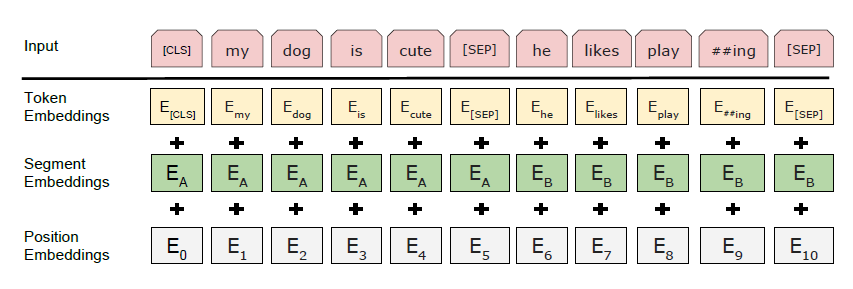

이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
인풋은 총 2개가 들어갑니다

* (토큰) 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것

* (세그멘트) 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.

* (포지션) 단어 순서에 따라서 자동으로 부여됩니다.

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [ ]:
sentence_load_data(["케라스로 버트 해보기 정말 재밌음", "케라스 쉬워 쉬워"])

100%|██████████| 2/2 [00:00<00:00, 2255.61it/s]

['[CLS]', '케', '##라', '##스로', '버', '##트', '해', '##보', '##기', '정', '##말', '재', '##밌', '##음', '[SEP]']
['[CLS]', '케', '##라', '##스', '쉬', '##워', '쉬', '##워', '[SEP]']


[array([[  101,  9806, 17342, 94980,  9336, 15184,  9960, 30005, 12310,
          9670, 89523,  9659,   100, 32158,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

이해가 되셨는지요?
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.

In [ ]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)


모델의 구조를 확인합니다.
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.

In [ ]:
model.summary()

가장 중요한 부분인데요, 사전학습 파일을 로드하여, 우리가 불러들였던 사전학습 모델을 변형해줍니다.

input으로는 우리가 문장을 토큰화 하여 숫자로 변형시켜주었던 토큰 벡터와, 앞문장인지 뒷문장인지 알려주는 세그멘트 두 가지가 되겠습니다.

즉 인풋은 inputs = model.inputs[:2]로 정의하였습니다.

그리고 output은 일단 사전학습 모델을 약간 잘라줍니다.(outputs=Dense(1)) 맨 위 3층을 잘라 낸다음에 잘라낸 부분에 긍정인지 부정인지 알려주는 Dense(1)을 사전학습 모델에 애드온 시켜 줍니다.

Dense(1)은 아웃풋이 하나로, 문장이 긍정에 가까우면 0에 가까운 값을, 부정에 가까우면 1에 가까운 값을 출력해주는 레이어입니다.

그리고 사전 설치하였던 Radam을 활용하여 deep learning의 기울기 강하 훈련을 하도록 정해줍니다. 그 다음에 bert_model을 return해 줍니다.

In [ ]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

In [ ]:
# 모델의 FLOW를 확인
from IPython.display import SVG
from keras.utils import model_to_dot

In [ ]:
SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

bert_model을 get_bert_finetuning_model 함수로 불러들입니다. 이 다음에 bert_model.fit을 활용하여 버트 모형 파인튜닝을 시작하게 됩니다. 실시간으로 테스트 데이터에 대한 정확도를 알기 위해 validation_data = (test_x, test_y)로 정하였습니다.

2 에포크 만에 정확도가 88.02%에 도달함을 알 수 있습니다.

만약에 ETRI에서 만든 한국어로 학습된 BERT 모형을 사용하면 정확도가 90%가 넘기도 합니다.(조만간 ETRI BERT를 활용하여 정확도 높이는 기법도 알려 드리겠습니다.)

사실 아무 전처리 없이 네이버 감성분석의 정확도가 2 에포크 만에 88.02%가 나온 것은 상당히 고무적인 것입니다.

BiLSTM 이나 어텐션 기법을 사용했을 시 보통 테스트셋에 대한 정확도가 86% 정도로 알려져 있습니다.

In [ ]:
tf.__version__ 

In [ ]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)